In [3]:
import time,os,re

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19
import OtherNetDefs
import InputPipeline
import OstagramTrainInputPipeline

In [4]:
BATCH_SIZE=10
NEW_H=256
NEW_W=256
input_shape = [BATCH_SIZE, 256, 256, 3]

In [5]:
train_path = 'ostagram_crawler/downloaded/'
C_batch, S_batch, G_batch, NUM_EXAMPLES = OstagramTrainInputPipeline.create_input_pipeline(train_path, BATCH_SIZE, NEW_H, NEW_W)
img_pred = OtherNetDefs.buildStyconNetMultiProduct(C_batch, S_batch)


  ----   DEBUG: image scale of InputPipeline will be [0,1], could try [0,255] and substract mean later.
conv layer, output size: [10, 336, 336, 32]
conv layer, output size: [10, 168, 168, 64]
conv layer, output size: [10, 84, 84, 128]
START residual_block 
conv layer, output size: [10, 82, 82, 128]
conv layer, output size: [10, 80, 80, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 78, 78, 128]
conv layer, output size: [10, 76, 76, 128]
END residual_block
conv layer, output size: [10, 336, 336, 32]
conv layer, output size: [10, 168, 168, 64]
conv layer, output size: [10, 84, 84, 128]
START residual_block 
conv layer, output size: [10, 82, 82, 128]
conv layer, output size: [10, 80, 80, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 78, 78, 128]
conv layer, output size: [10, 76, 76, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 74, 74, 128]
conv layer, output size: [10, 72, 72, 128]
END residual_block

In [6]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [17]:
loss = 2*tf.nn.l2_loss(img_pred - G_batch)
g, pred,l = sess.run([G_batch, img_pred,loss])

In [18]:
print l
print np.mean((g-pred)**2)

302542.0
0.153881


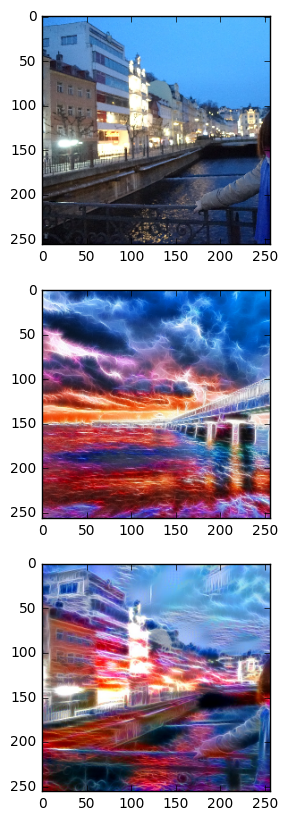

In [10]:
cnt = 0
while cnt < NUM_EXAMPLES:
    [c,s,g] = sess.run([C_batch, S_batch, G_batch])
    cnt += 10
    if cnt % 100 == 0:
        print ('%f%%' % (cnt/NUM_EXAMPLES))
        

(1, 886, 1024, 3) (1, 477, 765, 3) (1, 649, 751, 3)


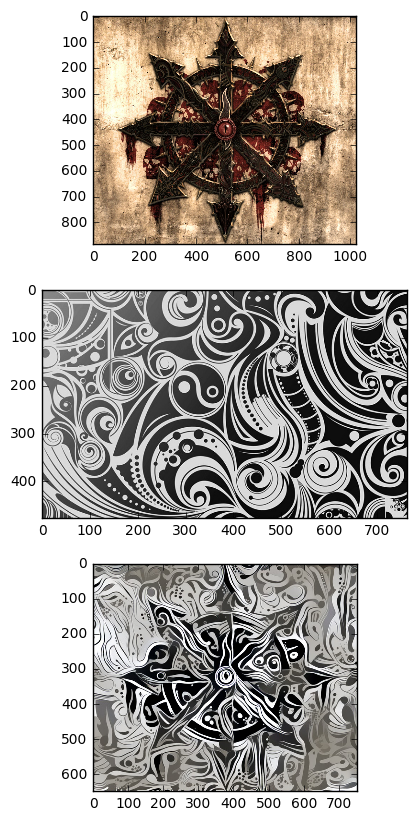

In [15]:
idx = np.random.choice(len(C_list))

c = Lib.load_image_as_batch_with_optional_resize(C_list[idx])
s = Lib.load_image_as_batch_with_optional_resize(S_list[idx])
g = Lib.load_image_as_batch_with_optional_resize(G_list[idx])
print c.shape,s.shape,g.shape
f,axes=plt.subplots(3,1, figsize=(10,10))
axes[0].imshow(c[0])
axes[1].imshow(s[0])
axes[2].imshow(g[0])
plt.show()